In [ ]:
%pip install pandas matplotlib seaborn plotly scikit-learn seaborn missingno

In [ ]:
!python -m pip install xgboost

In [177]:
from time import sleep

import matplotlib.pyplot as plt
import numpy as np
from sklearn import datasets, ensemble
from sklearn.inspection import permutation_importance
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, root_mean_squared_error
from sklearn.model_selection import train_test_split
import pandas as pd
from IPython.display import display, HTML
import missingno as mn
import seaborn as sns
import xgboost as xgb
import lightgbm

import warnings
warnings.filterwarnings('ignore')

sns.set()
RANDOM_SEED = 42

In [48]:
#Интерактивные графики в отдельном окне
%matplotlib tk

In [49]:
%matplotlib inline

In [50]:
!python -V

Python 3.11.3


# Загрузка данных

Сразу удалим дубликаты и проверим типы данных

In [178]:
df = pd.read_csv("autos.csv")
if df.duplicated().sum():
    df = df.drop_duplicates()

## Преобразование данных

In [179]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 354365 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354365 non-null  object
 1   Price              354365 non-null  int64 
 2   VehicleType        316875 non-null  object
 3   RegistrationYear   354365 non-null  int64 
 4   Gearbox            334532 non-null  object
 5   Power              354365 non-null  int64 
 6   Model              334660 non-null  object
 7   Kilometer          354365 non-null  int64 
 8   RegistrationMonth  354365 non-null  int64 
 9   FuelType           321470 non-null  object
 10  Brand              354365 non-null  object
 11  Repaired           283211 non-null  object
 12  DateCreated        354365 non-null  object
 13  NumberOfPictures   354365 non-null  int64 
 14  PostalCode         354365 non-null  int64 
 15  LastSeen           354365 non-null  object
dtypes: int64(7), object(9)
me

Видим множество признаков, с типами object. Даты преобразуем в datetime64. А прочие в категории.

In [180]:
df["DateCrawled"] = pd.to_datetime(df.DateCrawled)
df["DateCreated"] = pd.to_datetime(df.DateCreated)
df["LastSeen"] = pd.to_datetime(df.LastSeen)

categorical_cols = ["VehicleType", "Gearbox", "FuelType", "Brand", "Model", "Repaired"]
for category in categorical_cols:
    df[category] = df[category].astype("category")

In [139]:
df.describe().T

,count,mean,min,25%,50%,75%,max,std
DateCrawled,354365,2016-03-21 12:58:09.520460544,2016-03-05 14:06:22,2016-03-13 11:52:33,2016-03-21 17:50:55,2016-03-29 14:37:20,2016-04-07 14:36:58,NaN
Price,354365.0,4416.67983,0.0,1050.0,2700.0,6400.0,20000.0,4514.176349
RegistrationYear,354365.0,2004.234481,1000.0,1999.0,2003.0,2008.0,9999.0,90.228466
Power,354365.0,110.093816,0.0,69.0,105.0,143.0,20000.0,189.85133
Kilometer,354365.0,128211.363989,5000.0,125000.0,150000.0,150000.0,150000.0,37905.083858
RegistrationMonth,354365.0,5.71465,0.0,3.0,6.0,9.0,12.0,3.726432
DateCreated,354365,2016-03-20 19:12:06.583042560,2014-03-10 00:00:00,2016-03-13 00:00:00,2016-03-21 00:00:00,2016-03-29 00:00:00,2016-04-07 00:00:00,NaN
NumberOfPictures,354365.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
PostalCode,354365.0,50508.5038,1067.0,30165.0,49413.0,71083.0,99998.0,25783.100078
LastSeen,354365,2016-03-29 23:51:06.766184960,2016-03-05 14:15:08,2016-03-23 02:50:03,2016-04-03 15:15:52,2016-04-06 10:15:19,2016-04-07 14:58:51,NaN


Видим, что есть 
* нулевая Price
* нереальный RegistrationYear
* огромная Power

## Анализ данных на нормальность

df.hist(alpha=0.5, figsize=(20, 10), xrot=45)
plt.tight_layout()
plt.show()


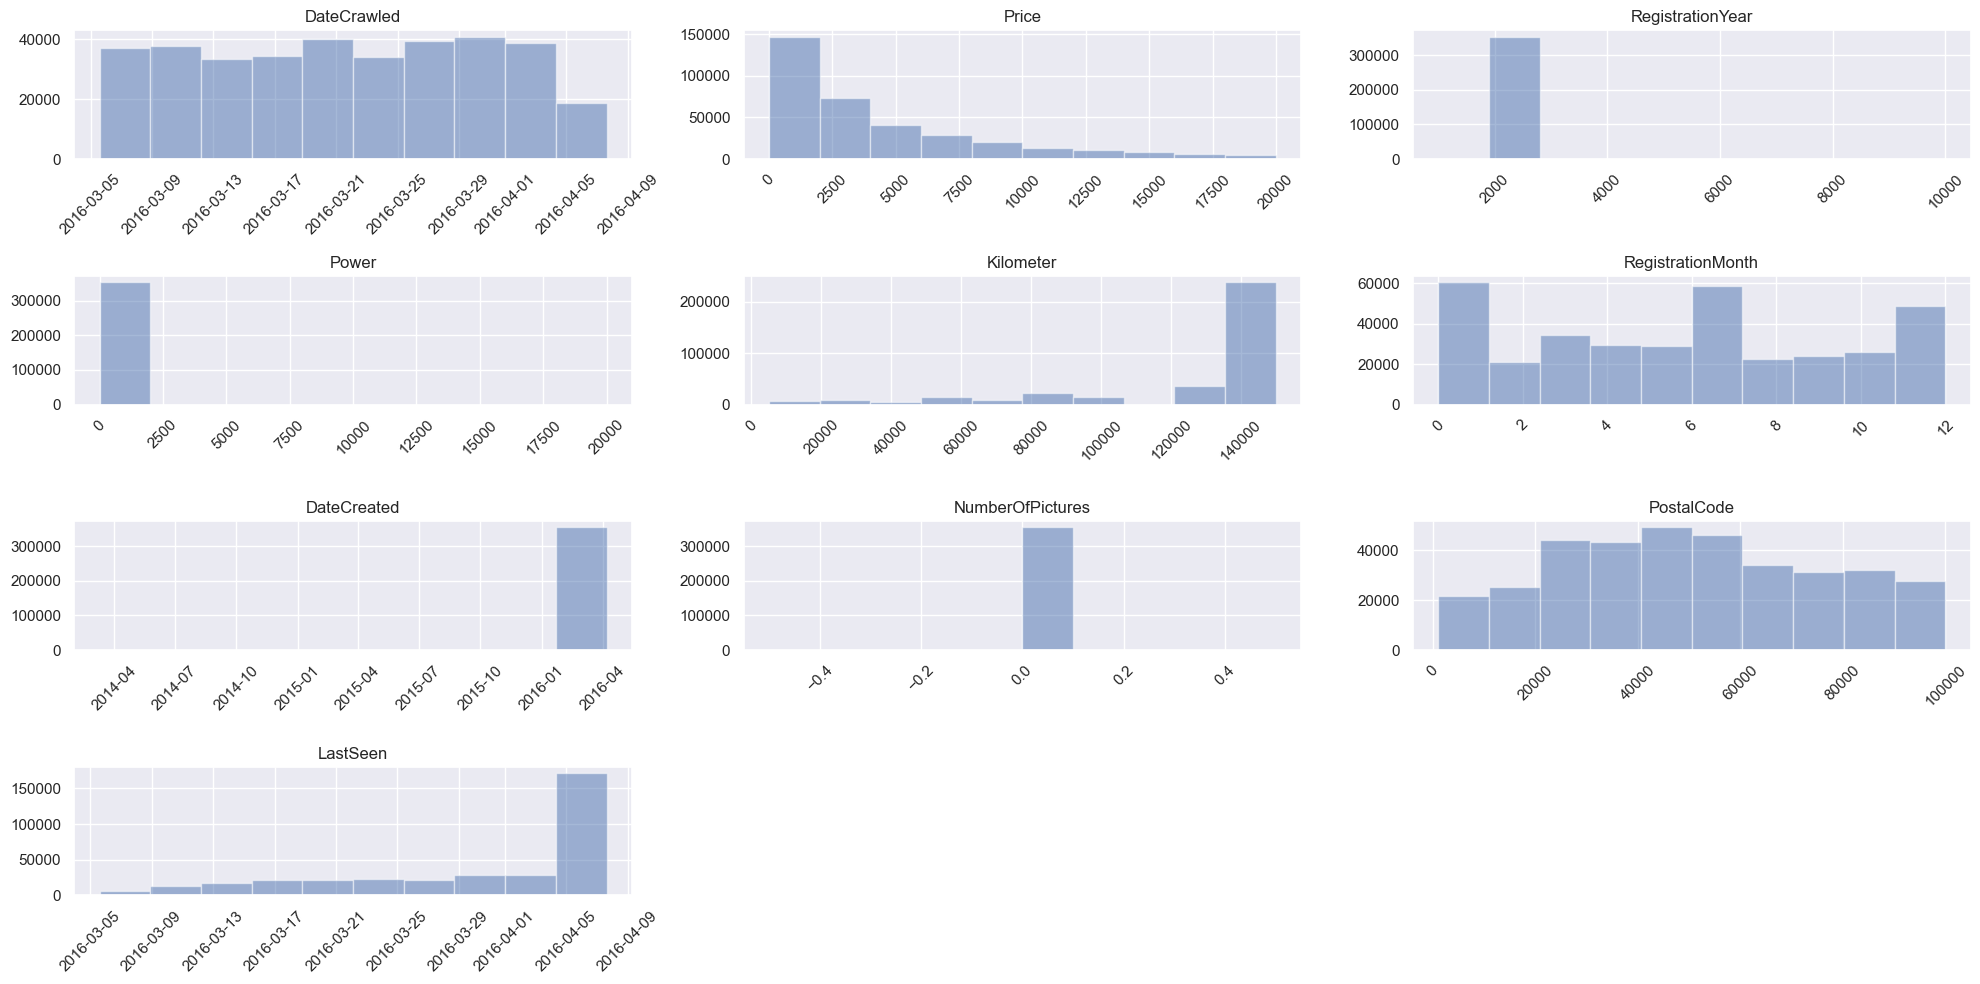

In [84]:
df.hist(alpha=0.5, figsize=(20, 10), xrot=45)
plt.tight_layout()
plt.show()


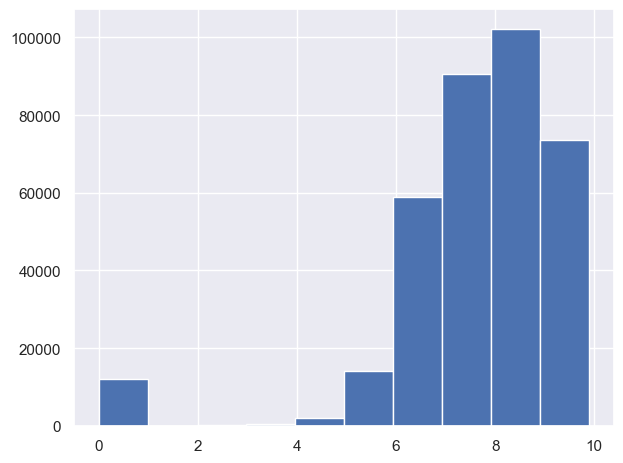

In [90]:
df["price_log"] = np.log1p(df["Price"])
df.price_log.hist()
plt.tight_layout()
plt.show()


In [ ]:
df = df.drop(columns=["price_log"]) 

Отбросим данные с ценой меньше 1

In [181]:
df = df.loc[df.Price > 1]

# Предобработка данных

## Поиск и обработка явно некорретных данных

### Обработка мощности

<Axes: xlabel='Power', ylabel='Count'>

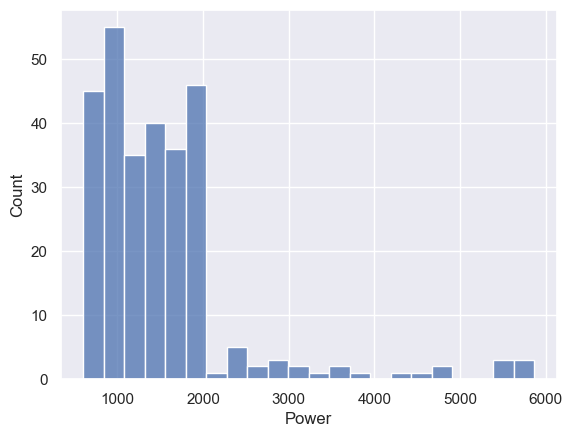

In [93]:
sns.histplot(df.Power.loc[(df.Power > 600) & (df.Power < 6000)])

#### Фильтрация неверной мощности через среднее (не используется)

Возможно пользователь ошибся и добавил лишние нули. Попробуем восстановить мощность по модели

Найдем среднее значение мощности для выбранных моделей

In [54]:
# huge_power_models = df.loc[df.Power > 600].Model.unique().tolist()
# median_power = {}
# for model in huge_power_models:
#     median = df["Power"].loc[df.Model == model].median()
#     try:
#         median_power[model] = round(median)
#     except ValueError:
#         print(model, "can't convert to int", median)
## Восстановим мощности
# df["Power"].update(df.loc[df.Power > 600]["Model"].map(median_power))
# df.describe().T
# df.loc[df['Power'] > 600, 'Power'] = np.nan

#### Преобразование неверной мощности в nan для последующего восстановления

Оставим только кореектную мощность, остальное преобразуем в nan

In [182]:
df['Power'] = df.Power.where(df.Power.between(10, 600))

### Обработка RegistrationDate

#### Найдем года, в которые не могло быть регистрации

In [142]:
df.RegistrationYear.loc[df.RegistrationYear > 2019].describe().T # Перебором года удалось выяснить граничный реальный год

count      82.000000
mean     6173.536585
std      2634.798627
min      2066.000000
25%      4200.000000
50%      5555.000000
75%      8972.000000
max      9999.000000
Name: RegistrationYear, dtype: float64

In [112]:
df.RegistrationYear.loc[df.RegistrationYear < 1900].describe().T

count      49.000000
mean     1180.489796
std       267.474463
min      1000.000000
25%      1000.000000
50%      1000.000000
75%      1300.000000
max      1800.000000
Name: RegistrationYear, dtype: float64

<Axes: >

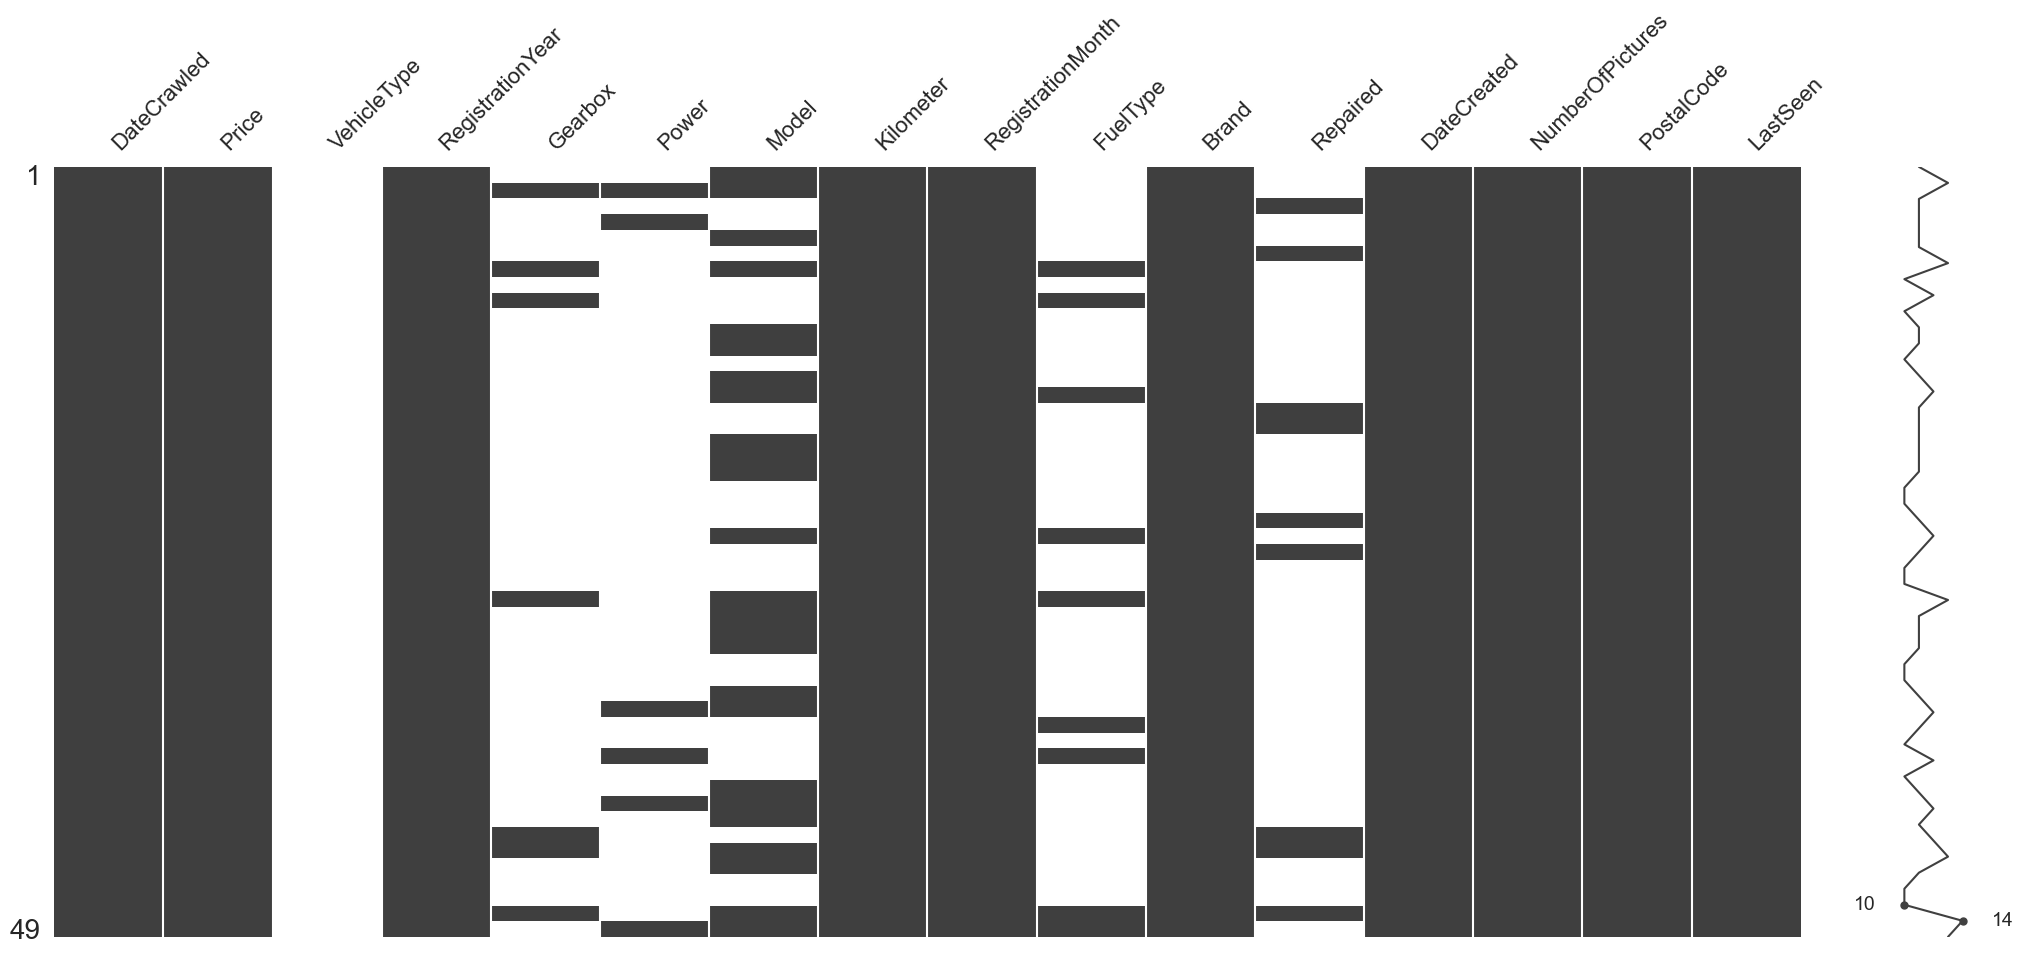

In [113]:
mn.missingno.matrix(df.loc[df.RegistrationYear < 1900])

<Axes: >

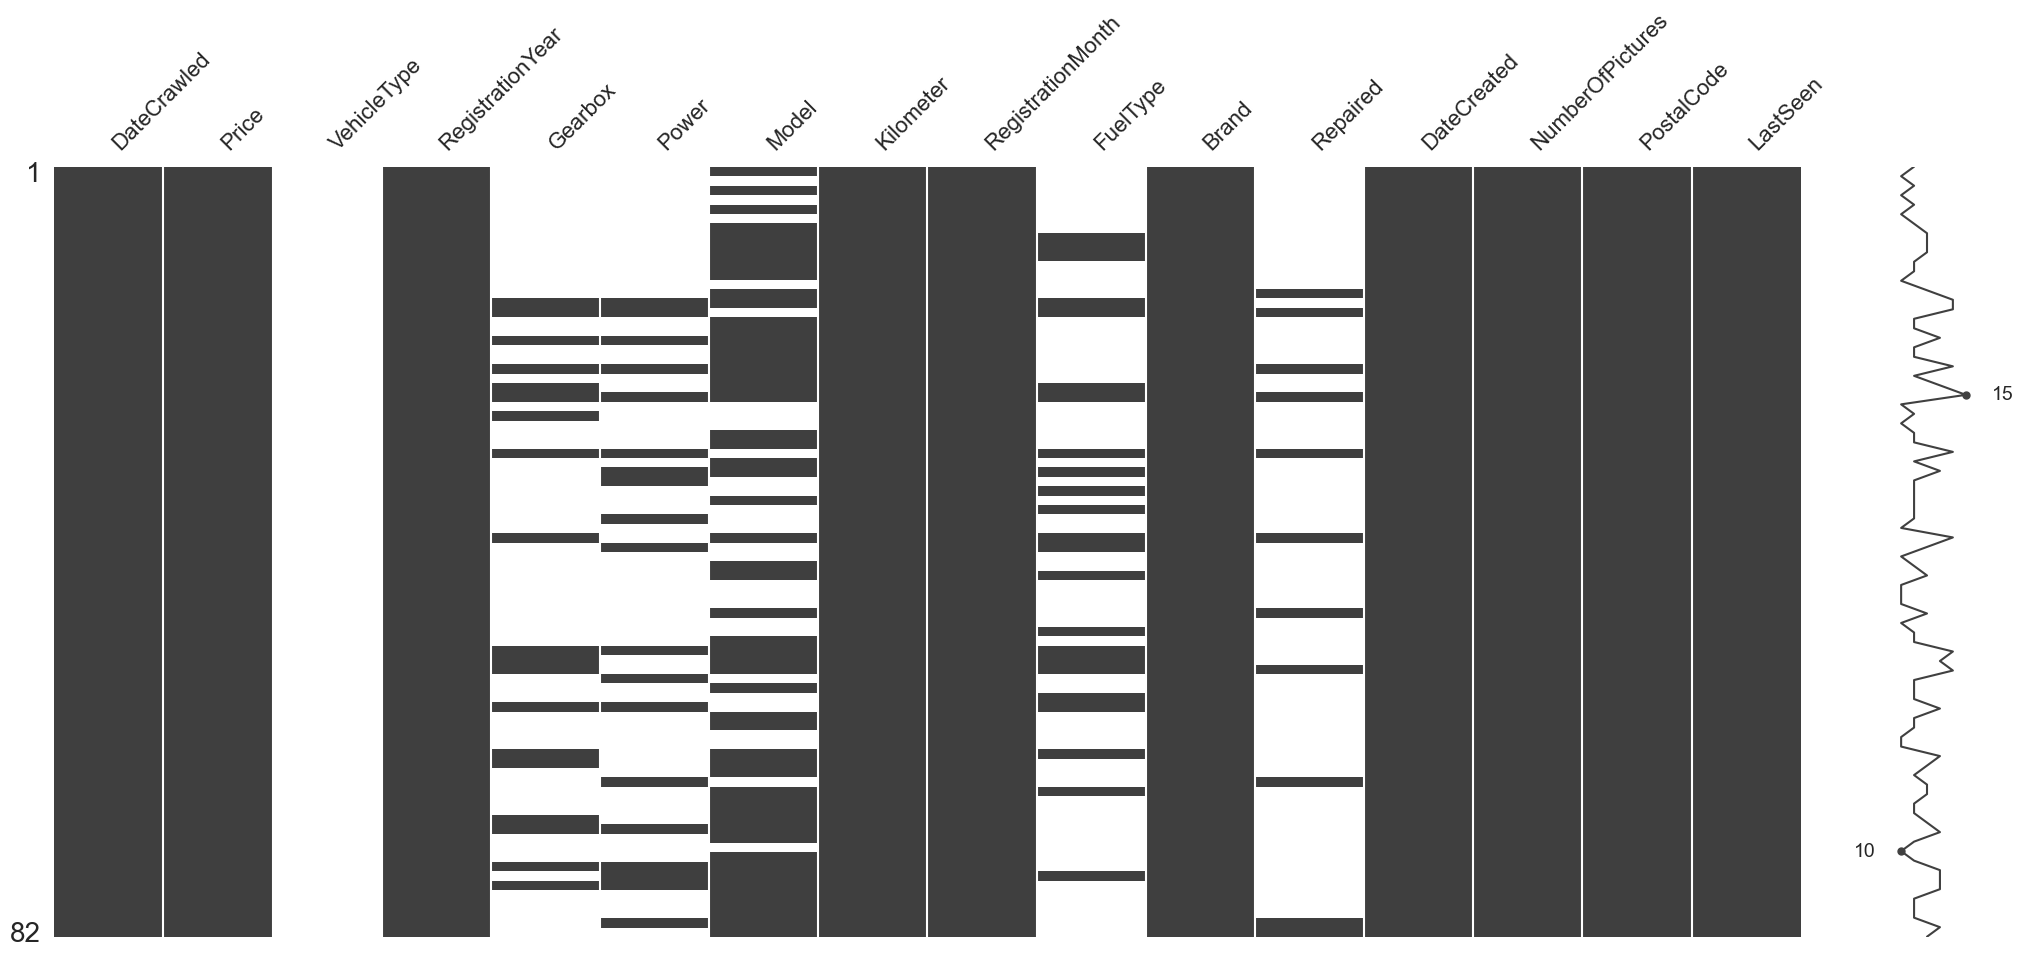

In [114]:
mn.missingno.matrix(df.loc[df.RegistrationYear > 2019])

#### Удаление данных с неверным годом регистрации

Как видно, пользователи не удосужились заполнить объявление. Т.к. таких объявлений не много, мы их удаляем.

In [183]:
df = (df.drop(df.loc[df.RegistrationYear > 2019].index).
         drop(df.loc[df.RegistrationYear < 1900].index))

### FuelType

In [184]:
df.FuelType.unique()

['petrol', 'gasoline', NaN, 'lpg', 'other', 'hybrid', 'cng', 'electric']
Categories (7, object): ['cng', 'electric', 'gasoline', 'hybrid', 'lpg', 'other', 'petrol']

Объедением petrol и gasoline, т.к. это одно и то же

In [185]:
df.FuelType = df.FuelType.replace(to_replace="gasoline", value="petrol")

## Обработка пропусков

### Удалим безнадежные данные

Удалим данные, которые не содержат полезной информации

In [187]:
df = (df.drop(df.loc[(df.Model.isnull()) & (df.Power.isnull())].index)
   .drop(df.loc[(df.Repaired.isnull()) & (df.Kilometer.isnull())].index)
   .drop(df.loc[(df.RegistrationYear.isnull()) &(df.Model.isnull())].index)
         )

### Заполнение категорий

#### Создадим функцию для обучения классификатора и заполнения пропусков

In [188]:

def predict_na_class(col_name: str, df_for_imputation: pd.DataFrame) -> pd.DataFrame:
    need_to_predict = df_for_imputation.loc[df_for_imputation[col_name].isnull()].drop(col_name, axis=1)
    train_set = df_for_imputation.drop(need_to_predict.index).dropna()
    
    X = train_set.drop(col_name, axis=1)
    y = train_set[col_name]
    
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.1, random_state=RANDOM_SEED)

    gbm = lightgbm.LGBMClassifier(random_state=33, early_stopping_rounds = 5, n_estimators=500)
    gbm.fit(X_train,  y_train, eval_set=[(X_test, y_test)])
    need_to_predict[col_name] =  gbm.predict(need_to_predict)
    df_for_imputation.loc[df_for_imputation[col_name].isna(), col_name] = need_to_predict[col_name].values
    return df_for_imputation

#### Изменим тип дат на int64


In [189]:
df["DateCrawled"] = df["DateCrawled"].astype("int64")
df["DateCreated"] = df["DateCreated"].astype("int64")
df["LastSeen"] = df["LastSeen"].astype("int64")

#### Запустим цикл заполнения пропусков

In [ ]:
df_for_imputation = df.copy().drop("Price", axis=1)
for col in ["VehicleType", "Gearbox", "Model", "FuelType", "Repaired"]:
    df_for_imputation = predict_na_class(col, df_for_imputation)
df_for_imputation["Price"] = df["Price"]
df = df_for_imputation.copy()

### Заполнение числовых признаков

#### Преобразуем категории в числовые значение

Создадим функцию для преобразование категории в Int

In [191]:
def category_to_dict(col: pd.Series):
    map_ = {}
    for count, category in enumerate(col.unique()):
        if pd.isna(np.array([category,])):
            continue
        map_[category] = count

    return map_

In [192]:
categories_map = {}
for category in categorical_cols:
    map_ = category_to_dict(df[category])
    categories_map[category] = map_
    df[category] = df[category].map(map_).astype("Int16")

#### Обучим модель и заполним мощность

In [ ]:
df_for_imputation = df.copy().drop("Price", axis=1)
col_name = "Power"
need_to_predict = df_for_imputation.loc[df_for_imputation[col_name].isnull()].drop(col_name, axis=1)
train_set = df_for_imputation.drop(need_to_predict.index).dropna()

X = train_set.drop(col_name, axis=1)
y = train_set[col_name]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, random_state=RANDOM_SEED)

gbm = lightgbm.LGBMRegressor(random_state=33, early_stopping_rounds = 5, n_estimators=500)
gbm.fit(X_train,  y_train, eval_set=[(X_test, y_test)], eval_metric='rmse')
need_to_predict[col_name] =  gbm.predict(need_to_predict)
df_for_imputation.loc[df_for_imputation[col_name].isna(), col_name] = need_to_predict[col_name].values
df_for_imputation["Price"] = df["Price"]
df = df_for_imputation.copy()

In [194]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
DateCrawled,337263.0,1458564945574957824.0,786720267944077.375,1457186782000000000.0,1457869510500000000.0,1458582557000000000.0,1459262590000000000.0,1460039818000000000.0
VehicleType,337263.0,2.985243,2.230757,0.0,0.0,3.0,5.0,7.0
RegistrationYear,337263.0,2003.227538,7.201182,1910.0,1999.0,2003.0,2008.0,2019.0
Gearbox,337263.0,0.194098,0.395505,0.0,0.0,0.0,0.0,1.0
Power,337263.0,118.8377,52.846659,-1.229358,75.0,110.0,145.0,600.0
Model,337263.0,48.582151,50.664888,0.0,11.0,32.0,71.0,249.0
Kilometer,337263.0,128644.470339,37003.073692,5000.0,125000.0,150000.0,150000.0,150000.0
RegistrationMonth,337263.0,5.830207,3.674379,0.0,3.0,6.0,9.0,12.0
FuelType,337263.0,0.055728,0.35675,0.0,0.0,0.0,0.0,5.0
Brand,337263.0,7.706179,7.518332,0.0,1.0,6.0,11.0,39.0


### Поиск коррелирующих данных

<Axes: >

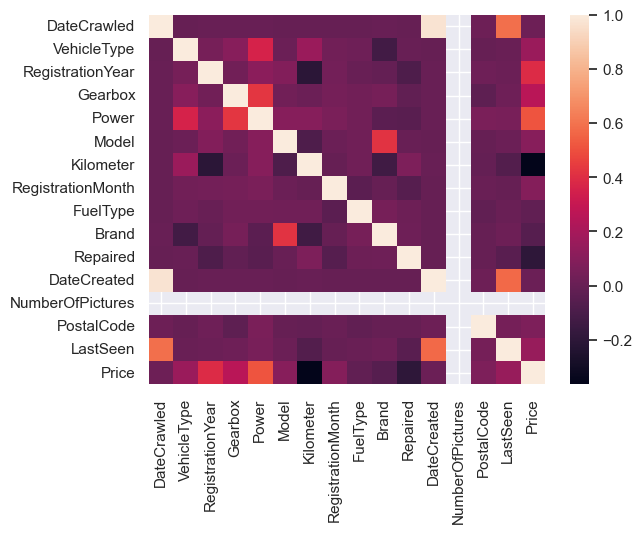

In [195]:
sns.heatmap(df.corr())

Коррелирующие пары

  * LastSeen - DateCrawled
  * LastSeen - DateCreated
  * DateCreated - DateCrawled

### Удаление коррелирующих признаков

In [196]:
df.drop(columns=["DateCrawled", "LastSeen", "NumberOfPictures"], inplace=True)

## Проверим влияние признаков

In [197]:
df_clear = df.copy().dropna()
num_features_to_select = 3
selector = SelectKBest(score_func=f_classif, k=num_features_to_select)
X = df_clear.drop("Price", axis=1)
y = df_clear["Price"]
selector.fit(X, y)

all_feature_scores = selector.scores_
feature_names = X.columns
for feature, score in zip(feature_names, all_feature_scores):
    print(f"Признак: {feature}, Оценка: {score}")

Признак: VehicleType, Оценка: 5.724077021370479
Признак: RegistrationYear, Оценка: 20.950593215759742
Признак: Gearbox, Оценка: 8.118320913039637
Признак: Power, Оценка: 37.034270014109595
Признак: Model, Оценка: 2.404502967411368
Признак: Kilometer, Оценка: 17.006854142565526
Признак: RegistrationMonth, Оценка: 3.3310638287378134
Признак: FuelType, Оценка: 0.962506624792603
Признак: Brand, Оценка: 1.7858328415583808
Признак: Repaired, Оценка: 10.222846548654545
Признак: DateCreated, Оценка: 1.140371301130602
Признак: PostalCode, Оценка: 1.8274307430458518


In [198]:
df.isna().sum()

VehicleType          0
RegistrationYear     0
Gearbox              0
Power                0
Model                0
Kilometer            0
RegistrationMonth    0
FuelType             0
Brand                0
Repaired             0
DateCreated          0
PostalCode           0
Price                0
dtype: int64

## Скалирование

In [208]:
X = df.drop('Price', axis=1)
y = df['Price']


In [200]:
scaler = StandardScaler()
scaler.fit(X) 

StandardScaler()

In [209]:
X = scaler.transform(X)

In [210]:
X = pd.DataFrame(X, index=y.index, columns=df.drop("Price", axis=1).columns)

In [211]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, random_state=RANDOM_SEED)

# Обучение

Через cross vlaidation


## XGBRegressor

In [214]:
from sklearn.model_selection import GridSearchCV
param_grid = {
    'max_depth': [5, 6],
    'n_estimators': [500, 550]
}


xgb_model = xgb.XGBRegressor()

grid_search = GridSearchCV(estimator = xgb_model, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 4)
grid_search.fit(X_train, y_train)


Fitting 3 folds for each of 4 candidates, totalling 12 fits


GridSearchCV(cv=3,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, max_bin=None,
                                    max_cat_threshold=None,
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=None, ...),
             n_jobs=-1,
             param_grid={'max_depth': [5, 6], 'n_estimators': [500, 550]},
             verbose=4)

In [215]:
root_mean_squared_error(y_test, grid_search.predict(X_test))

1606.3241304315848

## LightGBM

In [ ]:
!python -m pip install lightgbm


In [212]:

gbm3 = lightgbm.LGBMRegressor(random_state=33, early_stopping_rounds = 5, n_estimators=500)
gbm3.fit(X_train,  y_train, eval_set=[(X_test, y_test)], eval_metric='rmse')

[LightGBM] [Warning] early_stopping_round is set=5, early_stopping_rounds=5 will be ignored. Current value: early_stopping_round=5
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018986 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1008
[LightGBM] [Info] Number of data points in the train set: 303536, number of used features: 12
[LightGBM] [Warning] early_stopping_round is set=5, early_stopping_rounds=5 will be ignored. Current value: early_stopping_round=5
[LightGBM] [Info] Start training from score 4607.090826
Training until validation scores don't improve for 5 rounds
Did not meet early stopping. Best iteration is:
[498]	valid_0's rmse: 1643.72	valid_0's l2: 2.70183e+06


LGBMRegressor(early_stopping_rounds=5, n_estimators=500, random_state=33)

# Обработка идеальных данных

Предположим, что данные пришли без пропусков

In [228]:
df = pd.read_csv("autos.csv")
if df.duplicated().sum():
    df = df.drop_duplicates()
df["DateCrawled"] = pd.to_datetime(df.DateCrawled)
df["DateCreated"] = pd.to_datetime(df.DateCreated)
df["LastSeen"] = pd.to_datetime(df.LastSeen)

categorical_cols = ["VehicleType", "Gearbox", "FuelType", "Brand", "Model", "Repaired"]
for category in categorical_cols:
    df[category] = df[category].astype("category")
    
df = df.loc[df.Price > 1]

df['Power'] = df.Power.where(df.Power.between(10, 600))

df = (df.drop(df.loc[df.RegistrationYear > 2019].index).
         drop(df.loc[df.RegistrationYear < 1900].index))

df.FuelType = df.FuelType.replace(to_replace="gasoline", value="petrol")
df = df.dropna()

df["DateCrawled"] = df["DateCrawled"].astype("int64")
df["DateCreated"] = df["DateCreated"].astype("int64")
df["LastSeen"] = df["LastSeen"].astype("int64")

def category_to_dict(col: pd.Series):
    map_ = {}
    for count, category in enumerate(col.unique()):
        if pd.isna(np.array([category,])):
            continue
        map_[category] = count

    return map_

categories_map = {}
for category in categorical_cols:
    map_ = category_to_dict(df[category])
    categories_map[category] = map_
    df[category] = df[category].map(map_).astype("Int16")

X = df.drop('Price', axis=1)
y = df['Price']
scaler = StandardScaler()
scaler.fit(X)
X = scaler.transform(X)
X = pd.DataFrame(X, index=y.index, columns=df.drop("Price", axis=1).columns)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, random_state=RANDOM_SEED)

param_grid = {
    'n_estimators': [400, 500, 600]
}

# gbm = lightgbm.LGBMRegressor(random_state=33, early_stopping_rounds = 5, n_estimators=500)
# gbm.fit(X_train,  y_train, eval_set=[(X_test, y_test)], eval_metric='rmse')

gbm = lightgbm.LGBMRegressor(random_state=33, early_stopping_rounds = 5)
grid_search = GridSearchCV(gbm, param_grid = param_grid, 
                          cv = 10, n_jobs = -1, verbose = 4)
grid_search.fit(X_train,  y_train, eval_set=[(X_test, y_test)], eval_metric='rmse')
root_mean_squared_error(y_test, grid_search.predict(X_test))

Fitting 10 folds for each of 3 candidates, totalling 30 fits
[LightGBM] [Warning] early_stopping_round is set=5, early_stopping_rounds=5 will be ignored. Current value: early_stopping_round=5
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010406 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1499
[LightGBM] [Info] Number of data points in the train set: 209524, number of used features: 14
[LightGBM] [Warning] early_stopping_round is set=5, early_stopping_rounds=5 will be ignored. Current value: early_stopping_round=5
[LightGBM] [Info] Start training from score 5298.706950
Training until validation scores don't improve for 5 rounds
Did not meet early stopping. Best iteration is:
[599]	valid_0's rmse: 1506.92	valid_0's l2: 2.27079e+06


1506.915457933557

# Вывод

Бустинговые модели дают примерно одинаковый вариант на одинаковых выборках.

Исходные данные даны в достаточном количестве. Но среди них есть много данных, которые искажают результат и правильная их обработка оказывает значительное влияние.

* Безо всякой фильтрации, оставив только преобразование типов RMSE <strong>1738</strong>
  * Если не удалять пустые данные - RMSE <strong>1600</strong>
  * Со скалированием <strong>1579</strong>
* Удаление всех пустых - RMSE <strong>1615</strong>
  * Со скалированием <strong>1511</strong>
* Восстановление данных с помощью моделей привело к снижению точности до <strong>1600</strong>